In [42]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn import preprocessing
from tensorflow.keras import layers
import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Plotting style
sns.set_style("whitegrid")

In [4]:
from dataset import load_reader_dataset, load_mySugr_dataset, load_fitbit_dataset

## Load data from data sources

In [5]:
df = load_reader_dataset()
print(df.info())
print()

mysugr_df = load_mySugr_dataset()
print(mysugr_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49804 entries, 7955 to 1161
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    49804 non-null  datetime64[ns]
 1   Record Type             49804 non-null  int64         
 2   Glucose                 38337 non-null  float64       
 3   Scan Glucose (mmol/L)   10405 non-null  float64       
 4   Rapid Insulin           514 non-null    float64       
 5   Carbohydrates           368 non-null    float64       
 6   Long Insulin            80 non-null     float64       
 7   Strip Glucose (mmol/L)  51 non-null     float64       
 8   Previous Time           9 non-null      object        
 9   Updated Time            9 non-null      object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 4.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1787 entries, 1786 to 0
Data col

In [6]:
fitbit_df = load_fitbit_dataset()
print(fitbit_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214387 entries, 0 to 214386
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Time      214387 non-null  datetime64[ns]
 1   bpm       205117 non-null  float64       
 2   distance  214387 non-null  float64       
 3   calories  214387 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 8.2 MB
None


Concatenate individual dataframes into one dataframe

In [7]:
df = pd.concat([df, mysugr_df], ignore_index=True)

df = pd.concat([df, fitbit_df], ignore_index=True)

df.sort_values(by='Time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265978 entries, 0 to 265977
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    265978 non-null  datetime64[ns]
 1   Record Type             49804 non-null   float64       
 2   Glucose                 38337 non-null   float64       
 3   Scan Glucose (mmol/L)   10405 non-null   float64       
 4   Rapid Insulin           1051 non-null    float64       
 5   Carbohydrates           1605 non-null    float64       
 6   Long Insulin            184 non-null     float64       
 7   Strip Glucose (mmol/L)  51 non-null      float64       
 8   Previous Time           9 non-null       object        
 9   Updated Time            9 non-null       object        
 10  Date                    1787 non-null    object        
 11  Tags                    5 non-null       object        
 12  Insulin (Meal)          280 no

In [8]:
# Keeping relevant features
using_features = ['Time', 'Glucose', 'Rapid Insulin', 'Long Insulin', 'Carbohydrates', 'GI', 'calories', 'bpm', 'distance']
glucose_df = df[using_features]
glucose_df = glucose_df.dropna(subset=using_features, how='all')

# Filtering date range
start_date = "2021/12/01 00:00"
end_date = "2022/04/08 00:00"
glucose_df = glucose_df[(glucose_df["Time"] <= end_date) & (glucose_df["Time"] >= start_date)]

print(glucose_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204802 entries, 55911 to 240231
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Time           204802 non-null  datetime64[ns]
 1   Glucose        11970 non-null   float64       
 2   Rapid Insulin  640 non-null     float64       
 3   Long Insulin   126 non-null     float64       
 4   Carbohydrates  1372 non-null    float64       
 5   GI             1003 non-null    object        
 6   calories       184321 non-null  float64       
 7   bpm            180976 non-null  float64       
 8   distance       184321 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 15.6+ MB
None


### Identifying missing values

We expect a glucose data-point every 15 minutes, let's look at gaps bigger than 20 minutes as the sensor isn't always precise.

In [9]:
glucose_only = glucose_df[["Glucose", "Time"]].dropna()
deltas = glucose_only['Time'].diff()
gaps = deltas[deltas > pd.Timedelta(minutes=20)]

print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()} \n')

# Print some of the gaps
cnt = 0
for i, g in gaps.iteritems():
    if cnt > 10:
        break
    gap_end = glucose_only['Time'][i]
    print(f'End: {gap_end} | '
          f'Duration: {str(g.to_pytimedelta())}')
    cnt += 1

61 gaps with average gap duration: 0 days 01:13:59.016393442 

End: 2021-12-02 01:38:00 | Duration: 0:21:00
End: 2021-12-03 21:34:00 | Duration: 0:31:00
End: 2021-12-04 03:13:00 | Duration: 1:21:00
End: 2021-12-05 04:00:00 | Duration: 1:22:00
End: 2021-12-06 02:46:00 | Duration: 1:37:00
End: 2021-12-08 02:04:00 | Duration: 0:36:00
End: 2021-12-09 01:05:00 | Duration: 0:51:00
End: 2021-12-10 01:22:00 | Duration: 1:37:00
End: 2021-12-12 02:26:00 | Duration: 0:21:00
End: 2021-12-13 11:55:00 | Duration: 1:27:00
End: 2021-12-15 02:08:00 | Duration: 0:47:00


We should get rid of these gaps, we'll do so by interpolating, but only onn training and validation, we'll leave the testing dataset intact.

### Gaps in physical activity

In [10]:
ph_only = glucose_df[["Time", "distance", "calories", "bpm"]].copy().set_index('Time').resample('15T').agg(
    {
        'bpm':pd.Series.mean,
        'distance':pd.Series.mean,
        'calories':pd.Series.mean,
    }).reset_index()
total_ph_not_null = len(ph_only)
for col in ph_only:
    print(f"{(ph_only[col].isnull().sum()) / total_ph_not_null} missing in {col}")

0.0 missing in Time
0.007649117096590447 missing in bpm
0.0 missing in distance
0.0 missing in calories


## Preprocessing and feature engineering

### Creating time of day signal

In [10]:
glucose_df["Hour"] = glucose_df.apply(lambda row: row["Time"].hour, axis=1)
using_features.append("Hour")

### Encode Glycemic index

In [11]:
GI_valus = ["Low", "Medium", "High", "Very High"]
glucose_df["GI"] = glucose_df.apply(lambda row: row["GI"] if row["GI"] in GI_valus else np.nan, axis=1)

# Encode as ordinal features
enc = {
    "Low": 15,
    "Medium": 45,
    "High": 75,
    "Very High": 95,
    np.nan: 0
}
glucose_df["GI"] = glucose_df["GI"].map(enc)

# What we realy want to use is Glycemic load, calculated as (GI * grams_of_carbohydrates) / 100
glucose_df["Glycemic Load"] = glucose_df["GI"] * glucose_df["Carbohydrates"] / 100

using_features.remove("GI")
using_features.append("Glycemic Load")

print(glucose_df.info())
print(glucose_df["Glycemic Load"].dropna())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204802 entries, 55911 to 240231
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Time           204802 non-null  datetime64[ns]
 1   Glucose        11970 non-null   float64       
 2   Rapid Insulin  640 non-null     float64       
 3   Long Insulin   126 non-null     float64       
 4   Carbohydrates  1372 non-null    float64       
 5   GI             204802 non-null  int64         
 6   calories       184321 non-null  float64       
 7   bpm            180976 non-null  float64       
 8   distance       184321 non-null  float64       
 9   Hour           204802 non-null  int64         
 10  Glycemic Load  1372 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 18.8 MB
None
28236     0.00
28243     0.00
28264     0.00
28279     0.00
28319     0.00
         ...  
51264     5.70
51265     5.70
51267    10.35

#### Resampling

In [12]:
def resample_data(in_df, min_freq=15):
    resampl_df = in_df.copy()
    resampl_df = resampl_df.set_index('Time').resample(f'{min_freq}T').agg(
        {
            'Glucose':pd.Series.mean,
            'Rapid Insulin':pd.Series.sum,
            'Long Insulin':pd.Series.sum,
            'Carbohydrates':pd.Series.sum,
            'Glycemic Load':pd.Series.sum,
            'bpm':pd.Series.mean,
            'distance':pd.Series.sum,
            'calories':pd.Series.sum,
            'Hour':pd.Series.mean
        }).reset_index()
    return resampl_df

In [13]:
ORIG_FREQ = 15
SAMPL_FREQ = 15
FREQ_CORRECTION = ORIG_FREQ // SAMPL_FREQ

glucose_df_resampled = resample_data(glucose_df, SAMPL_FREQ)

### Feature engineering for insulin

In [14]:
# Create a 6 day rolling window for insulin
days = 6
roll_window_width = days * 24 * 60 // SAMPL_FREQ
glucose_df_resampled['Rapid Insulin 6d'] = (glucose_df_resampled['Rapid Insulin'].rolling(roll_window_width).sum() / days)
glucose_df_resampled['Rapid Insulin 6d'].replace(to_replace=np.nan, method='bfill', inplace=True)

using_features.append('Rapid Insulin 6d')

# Long insulin acts for approximately 24 hours, stretch the data across this period
glucose_df_resampled['Long Insulin'].replace(to_replace=0, method='ffill', inplace=True)

In [15]:
glucose_df_resampled

,Time,Glucose,Rapid Insulin,Long Insulin,Carbohydrates,Glycemic Load,bpm,distance,calories,Hour,Rapid Insulin 6d
0,2021-12-01 00:00:00,7.3,0.0,15.0,0.0,0.00,60.312381,22.9,19.59,0.0,23.166667
1,2021-12-01 00:15:00,8.0,0.0,15.0,0.0,0.00,63.833466,73.5,17.96,0.0,23.166667
2,2021-12-01 00:30:00,8.6,0.0,15.0,0.0,0.00,51.559524,5.5,17.86,0.0,23.166667
3,2021-12-01 00:45:00,8.8,0.0,15.0,0.0,0.00,54.447937,0.0,17.62,0.0,23.166667
4,2021-12-01 01:00:00,9.1,0.0,15.0,0.0,0.00,51.072959,0.0,21.17,1.0,23.166667
...,...,...,...,...,...,...,...,...,...,...,...
12284,2022-04-07 23:00:00,8.6,0.0,9.0,5.0,2.25,72.603725,40.1,56.75,23.0,24.500000
12285,2022-04-07 23:15:00,8.6,0.0,9.0,0.0,0.00,70.983362,17.2,52.45,23.0,24.500000
12286,2022-04-07 23:30:00,8.4,0.0,9.0,0.0,0.00,78.193862,155.5,60.42,23.0,24.500000
12287,2022-04-07 23:45:00,8.9,0.0,9.0,0.0,0.00,84.487015,255.4,60.95,23.0,24.500000


## Using insulin activity curves

In [16]:
# Source: https://github.com/LoopKit/Loop/issues/388
# Time duration [minutes] , 3-6 hours for Fiasp
td = 5*60
# Peak activity time [minutes], 45-85 minutes
tp = 55
# Time constant of exponential decay
tau = tp*(1-tp/td)/(1-2*tp/td)
# Rise time factor
a = 2*tau/td
# Auxiliary scale factor
S = 1/(1-a+(1+a)*math.exp(-td/tau))

# Insulin activity function of time
# Ia(t) = (S/tau^2)*t*(1-t/td)*exp(-t/tau)
def insulin_activity(t):
    return (S/tau**2)*t*(1-t/td)*math.exp(-t/tau)

# Insulin on board function
# IOB(t) = 1-S*(1-a)*((t^2/(tau*td*(1-a)) - t/tau - 1)*exp(-t/tau)+1)
def insulin_on_board(t):
    return 1-S*(1-a)*( (t**2/(tau*td*(1-a)) - t/tau - 1)*math.exp(-t/tau)+1)

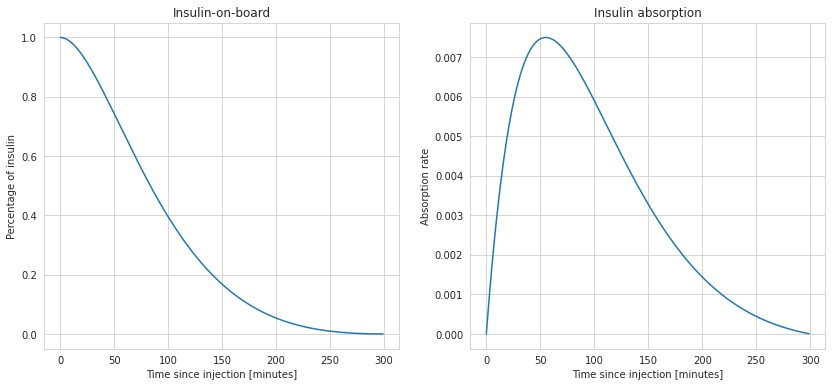

In [18]:
iob = [insulin_on_board(x) for x in range(0, td)]
ia = [insulin_activity(x) for x in range(0, td)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(iob)
ax1.set_title('Insulin-on-board')
ax1.set_xlabel("Time since injection [minutes]")
ax1.set_ylabel("Percentage of insulin")

ax2.plot(ia)
ax2.set_title('Insulin absorption')
ax2.set_xlabel("Time since injection [minutes]")
ax2.set_ylabel("Absorption rate")

plt.savefig(fname="figures/insulin_curves.png");

### Create new Insulin on board feature

In [17]:
def insulin_on_board_vector(iob_window, dose):
    w_len = len(iob_window)
    result = [current_iob for current_iob in iob_window]
    for i in range(w_len):
        result[i] += dose * insulin_on_board(i * SAMPL_FREQ)
    return result

In [18]:
glucose_df_resampled["Rapid Insulin IOB"] = 0

max_n = len(glucose_df_resampled)

duration_samples = td // SAMPL_FREQ
for idx, data in glucose_df_resampled.iterrows():
    # Insulin injected
    if data["Rapid Insulin"] != 0:
        idx = int(idx)
        dur_end = int(min(idx + duration_samples, max_n))
        ins_dose = data["Rapid Insulin"]
        glucose_df_resampled.loc[slice(int(idx), dur_end), "Rapid Insulin IOB"] = \
            insulin_on_board_vector(glucose_df_resampled.loc[slice(int(idx), dur_end), "Rapid Insulin IOB"], ins_dose)

using_features.append("Rapid Insulin IOB")

#### Data split

In [19]:
def train_val_test_split(df_in):
    n = len(df_in)
    return df_in[0:int(n*0.7)].copy(), df_in[int(n*0.7):int(n*0.9)].copy(), df_in[int(n*0.9):].copy(), n

train_df, val_df, test_df, n = train_val_test_split(glucose_df_resampled)
num_features = glucose_df_resampled.shape[1]

In [20]:
def interpolate_gaps(in_df, method="linear"):
    if method in ["spline", "polynomial"]:
        in_df["Glucose"] = in_df["Glucose"].interpolate(method=method, order=2)
        if "bpm" in in_df.columns:
            in_df["bpm"] = in_df["bpm"].interpolate(method=method, order=2)
    else:
        in_df["Glucose"] = in_df["Glucose"].interpolate(method=method)
        if "bpm" in in_df.columns:
            in_df["bpm"] = in_df["bpm"].interpolate(method=method)

In [21]:
interpolate_gaps(train_df)
interpolate_gaps(val_df)

# Drop any nans from test dataset (we're not interpolating it to keep original data)
test_df = test_df.dropna(subset=["Glucose"])

In [22]:
print(train_df.info())
print(val_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8602 entries, 0 to 8601
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               8602 non-null   datetime64[ns]
 1   Glucose            8602 non-null   float64       
 2   Rapid Insulin      8602 non-null   float64       
 3   Long Insulin       8602 non-null   float64       
 4   Carbohydrates      8602 non-null   float64       
 5   Glycemic Load      8602 non-null   float64       
 6   bpm                8602 non-null   float64       
 7   distance           8602 non-null   float64       
 8   calories           8602 non-null   float64       
 9   Hour               8602 non-null   float64       
 10  Rapid Insulin 6d   8602 non-null   float64       
 11  Rapid Insulin IOB  8602 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 806.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458 e

### Normalization

In [23]:
def standard_normalize(train_df, val_df, test_df, features):
    std_scaler = preprocessing.StandardScaler()
    train_df[features] = std_scaler.fit_transform(train_df[features])

    val_df[features] = std_scaler.transform(val_df[features])
    test_df[features] = std_scaler.transform(test_df[features])
    return std_scaler

# Z-score normalization
def z_score_normalize(train_df, val_df, test_df, features):
    for feature in features:
        _mean = train_df[feature].mean()
        _std = train_df[feature].std()

        train_df.loc[:, feature] -= _mean
        val_df.loc[:, feature] -= _mean
        test_df.loc[:, feature] -= _mean
        train_df.loc[:, feature] /= _std
        val_df.loc[:, feature] /= _std
        test_df.loc[:, feature] /= _std

def min_max_normalize(train_df, val_df, test_df, features):
    min_max_scaler = preprocessing.MinMaxScaler()
    train_df[features] = min_max_scaler.fit_transform(train_df[features])

    val_df[features] = min_max_scaler.transform(val_df[features])
    test_df[features] = min_max_scaler.transform(test_df[features])
    return min_max_scaler

min_max_scaler = min_max_normalize(train_df, val_df, test_df, [col for col in using_features if col != "Time"])

In [24]:
train_df

,Time,Glucose,Rapid Insulin,Long Insulin,Carbohydrates,Glycemic Load,bpm,distance,calories,Hour,Rapid Insulin 6d,Rapid Insulin IOB
0,2021-12-01 00:00:00,0.27500,0.0,0.476190,0.0,0.0,0.158181,0.019894,0.033080,0.000000,0.352113,1.775031e-16
1,2021-12-01 00:15:00,0.31875,0.0,0.476190,0.0,0.0,0.200089,0.063852,0.017174,0.000000,0.352113,1.775031e-16
2,2021-12-01 00:30:00,0.35625,0.0,0.476190,0.0,0.0,0.054003,0.004778,0.016198,0.000000,0.352113,1.775031e-16
3,2021-12-01 00:45:00,0.36875,0.0,0.476190,0.0,0.0,0.088381,0.000000,0.013856,0.000000,0.352113,1.775031e-16
4,2021-12-01 01:00:00,0.38750,0.0,0.476190,0.0,0.0,0.048212,0.000000,0.048497,0.043478,0.352113,1.775031e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
8597,2022-02-28 13:15:00,0.30000,0.0,0.238095,0.0,0.0,0.369700,0.025367,0.074356,0.565217,0.830986,4.071472e-01
8598,2022-02-28 13:30:00,0.31250,0.0,0.238095,0.0,0.0,0.432611,0.032578,0.113193,0.565217,0.830986,3.299168e-01
8599,2022-02-28 13:45:00,0.32500,0.0,0.238095,0.0,0.0,0.416071,0.000000,0.010246,0.565217,0.830986,2.625120e-01
8600,2022-02-28 14:00:00,0.35000,0.0,0.238095,0.0,0.0,0.377408,0.014421,0.067916,0.608696,0.830986,2.052973e-01


## Making Time-series predictions

In [25]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series
class WindowGenerator:
    def __init__(
            self, input_width, label_width, shift,
            train_df_in, val_df_in, test_df_in,
            label_columns=None, batch_size=32, input_smpl_rate=pd.Timedelta(minutes=17),
            drop_noisy=False, noisy_period=None, use_columns=None, look_ahead_columns=None
    ):
        """
        Provides data windowing and plotting capabilities
        :param input_width: Size of the input window
        :param label_width: Size of the output window (single step or multiple)
        :param shift: The prediction horizon
        :param train_df_in:
        :param val_df_in:
        :param test_df_in:
        :param label_columns:
        :param batch_size:
        :param input_smpl_rate:
        :param drop_noisy: If true, windows are trimmed off when there is noise between current time and the predicted time step
        :param noisy_period: Configurable noisy period, if None, it is same as the shift
        :param use_columns: Columns to pick to be used from the passed dataframes
        :param look_ahead_columns: Columns whose future values can be used as inputs
        """
        if isinstance(input_width, list):
            assert len(input_width) == len([c for c in use_columns if c != "Time"]), "Input widths and number of columns to use must match"

        if look_ahead_columns is None:
            look_ahead_columns = []
        if use_columns is None:
            use_columns = ["Time", "Glucose"]

        self.train_df = train_df_in[use_columns].drop("Time", axis=1)
        self.val_df = val_df_in[use_columns].drop("Time", axis=1)
        self.test_df = test_df_in[use_columns].drop("Time", axis=1)
        self.train_df_all, self.val_df_all, self.test_df_all = train_df_in, val_df_in, test_df_in

        self.input_smpl_rate = input_smpl_rate
        self.batch_size = batch_size
        self.drop_noisy = drop_noisy
        self.noisy_period = noisy_period
        continuous_columns = ["Time", "Glucose", "bpm", "distance", "calories", "calories 30m", "Hour",
                              "Rapid Insulin 6d", "Rapid Insulin IOB", "Long Insulin"]
        self.noisy_columns = [col for col in self.train_df_all.columns if col not in continuous_columns]
        self.using_columns = [col for col in use_columns if col != "Time"]

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}

        self.look_ahead_columns = {self.column_indices[col]: val for col, val in look_ahead_columns}

        # Work out the window parameters, if we have a list for input width, one width per each
        # feature than take the max and preserve information about slices widths for all the features
        if isinstance(input_width, list):
            self.feature_input_widths = input_width
            self.input_width = max(self.feature_input_widths)
        else:
            self.feature_input_widths = None
            self.input_width = input_width

        self.label_width = label_width
        self.shift = shift

        self.total_window_size = self.input_width + shift

        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window_variable(self, features):
        """
        Slices the window variably for each feature based on the individual feature widths
        :param features: Flattened array of feature inputs
        :return:
        """
        n_of_features = len(self.using_columns)
        for idx, feature_width in enumerate(self.feature_input_widths):
            feature_start = self.input_width * n_of_features - feature_width * n_of_features + idx
            feature_end = feature_start + feature_width * n_of_features
            if idx in self.look_ahead_columns:
                feature_end += self.look_ahead_columns[idx] * n_of_features

            feature_slice = features[:, slice(feature_start, feature_end, n_of_features)]
            if idx > 0:
                inputs = tf.concat([inputs, feature_slice], 1)
            else:
                inputs = feature_slice

        labels_start = self.total_window_size * n_of_features - self.label_width * n_of_features
        # +1 since we only want to predict BG (first value in the flattened data)
        labels = features[:, slice(labels_start, labels_start + 1)]

        inputs_lengths = sum(self.feature_input_widths)
        inputs_lengths += sum(look_ahead_len for look_ahead_len in self.look_ahead_columns.values())

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, inputs_lengths])
        labels.set_shape([None, self.label_width])
        return inputs, labels

    def split_window(self, features):
        """
        Take the same slice from all the features
        :param features:
        :return:
        """
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='Glucose', max_subplots=3, save_file=None, label_title="Targets"):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        win_to_plot = [x for x in range(0, len(inputs), len(inputs) // max_n)]
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[win_to_plot[n], :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label=label_title, c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if len(predictions.shape) > 2:
                    plt.scatter(self.label_indices, predictions[win_to_plot[n], :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
                else:
                    plt.scatter(self.label_indices, predictions[win_to_plot[n], label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time, 15-minute sampling rate')

        if save_file:
            plt.tight_layout(pad=0.5)
            plt.savefig(fname=f"figures/{save_file}.png")

    def make_dataset(self, data, drop_last=False):
        data = np.array(data, dtype=np.float32)
        ds = self.single_ds(data, True)
        ds = ds.map(self.split_window)
        if drop_last:
            ds = ds.take(len(ds) - 1)
        return ds

    def single_ds(self, data, is_batched=True):
        return tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            # Move the window one by one (overlapping windows)
            sequence_stride=1,
            shuffle=True,
            batch_size=(self.batch_size if is_batched else 1)
        )

    def make_dataset_w_pandas(self, data, is_batched=True):
        data = data.copy()
        # Identify gaps
        data["Gap"] = data["Time"].diff() > self.input_smpl_rate

        print(len(data[data["Gap"] == True]), " gaps identified")

        # Create windows (stride=1)
        data = data.drop("Time", axis=1)
        rolling_windows = data.rolling(window=self.total_window_size)

        # Filter out gaps and take full windows of np.array
        np_windows = []
        window_count = 0
        noise_end = self.input_width + self.noisy_period if self.noisy_period else None
        for _w in rolling_windows:
            window_count += 1
            # Not a full window
            if len(_w) < self.total_window_size:
                continue
            # Drop windows which contain any noise (non-glucose features) in the time now and time of prediction
            # as this can skew the input-output mapping
            if self.drop_noisy and not (_w[self.noisy_columns][slice(self.input_width, noise_end)] == 0).all().all():
                continue
            # Also drop any windows with considerable physical activity
            if self.drop_noisy and "calories" in self.train_df_all.columns and (_w["calories"][slice(self.input_width, noise_end)] > 0.6).any().any():
                continue
            # Drop windows with time gaps in them
            if True in _w["Gap"]:
                continue

            # Flatten if we have differently sized windows for individual input features
            if self.feature_input_widths:
                np_windows.append(np.array(_w[self.using_columns], dtype=np.float32).flatten())
            else:
                np_windows.append(np.array(_w[self.using_columns], dtype=np.float32))

        if self.drop_noisy:
            print(window_count, "size before reduction")
            print(len(np_windows), "size after reduction")

        # Tensorflow dataset
        ds = tf.data.Dataset.from_tensor_slices(np_windows)
        ds = ds.batch(self.batch_size if is_batched else 1)
        if self.feature_input_widths:
            ds = ds.map(self.split_window_variable)
        else:
            ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        if not getattr(self, '_train_cache', None):
            self._train_cache = self.make_dataset_w_pandas(self.train_df_all)
        return self._train_cache

    @property
    def val(self):
        if not getattr(self, '_val_cache', None):
            self._val_cache = self.make_dataset_w_pandas(self.val_df_all)
        return self._val_cache

    @property
    def test(self):
        if not getattr(self, '_test_cache', None):
            self._test_cache = self.make_dataset_w_pandas(self.test_df_all, False)
        return self._test_cache

    @property
    def train_and_val(self):
        if not getattr(self, '_train_and_val_cache', None):
            self._train_and_val_cache = self.make_dataset_w_pandas(pd.concat([self.train_df_all, self.val_df_all]))
        return self._train_and_val_cache

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Helper functions

In [26]:
MMOL_TO_MGDL = 18.016

def get_window(columns_to_use, input_width, label_width, shift, batch_size=32, drop_noisy=False, noisy_period=None, look_ahead_columns=[]):
    return WindowGenerator(
        input_width=input_width*FREQ_CORRECTION,
        label_width=label_width if label_width == 1 else label_width*FREQ_CORRECTION,
        shift=shift*FREQ_CORRECTION,
        train_df_in=train_df,
        val_df_in=val_df,
        test_df_in=test_df,
        batch_size=batch_size,
        label_columns=["Glucose"],
        use_columns=columns_to_use,
        drop_noisy=drop_noisy,
        noisy_period=noisy_period,
        look_ahead_columns=look_ahead_columns
    )

def model_fit(model, window, patience=2, max_epochs=10, monitor='val_loss', final_train=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                patience=patience,
                                                mode='min')
    if final_train:
        history = model.fit(window.train_and_val, epochs=max_epochs, validation_data=window.val, callbacks=[early_stopping])
    else:
        history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=[early_stopping])
    return history

def compile_and_fit(model, window, patience=2, max_epochs=10, monitor='val_loss', final_train=False):
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])
    history = model_fit(model, window, patience, max_epochs, monitor, final_train)
    return history

def save_model(model, name):
    model.save(f'models/{name}')

def z_score_normalized_err_to_orig(perf):
    # Verify if std**2 is all that is needed for de-normalization
    std = math.sqrt(std_scaler.var_)
    return {k: [x * 1/std**2 for x in v] for k, v in perf.items()}

def min_max_normalized_err_to_orig(perf):
    d_max, d_min = min_max_scaler.data_max_[0], min_max_scaler.data_min_[0]
    err_inverse = (d_max - d_min)
    return {k: [err_inverse * x for x in v] for k, v in perf.items()}

def from_mmol_to_dgl(perf):
    return {k: [MMOL_TO_MGDL * x for x in v] for k, v in perf.items()}

def bg_denormalize(norm_val, unit_to="mgdl"):
    d_max, d_min = min_max_scaler.data_max_[0], min_max_scaler.data_min_[0]
    orig = norm_val * (d_max - d_min) + d_min
    if unit_to == "mgdl":
        orig *= MMOL_TO_MGDL
    return orig

def show_performance(perf, units="norm"):
    if units == "norm":
        pass
    elif units == "mmol":
        perf = min_max_normalized_err_to_orig(perf)
    elif units == "mgdl":
        perf = from_mmol_to_dgl(min_max_normalized_err_to_orig(perf))
    for mod_perf, perf_data in perf.items():
        if isinstance(perf_data, list):
            print(mod_perf, perf_data[1])
        else:
            print(mod_perf, perf_data)

def get_flat_arrays(data_in):
    x_arr, y_arr = [], []
    for x, y in data_in:
        x_arr.append(x.numpy().flatten())
        y_arr.append(y.numpy().flatten())
    return x_arr, np.ravel(y_arr)

### Investigating windows

### Number of windows and samples dropped

Samples dropped due to calories threshold

In [237]:
max_calories_seen = max(glucose_df_resampled["calories"])
real_calories_threshold = 0.6 * max_calories_seen
print("Calories threshold ", real_calories_threshold)
print("Dropped % due to calories threshold",
      len(glucose_df_resampled[glucose_df_resampled["calories"] > real_calories_threshold]) / len(glucose_df_resampled["calories"])
)

Calories threshold  81.17399999999999
Dropped % due to calories threshold 0.01765806819106518


2 hour prediction horizon

In [226]:
window = get_window(["Time", "Glucose"], 8, 1, 8, drop_noisy=True)
window.train
window.val
window.test

0  gaps identified
8602 size before reduction
3466 size after reduction
0  gaps identified
2458 size before reduction
868 size after reduction
18  gaps identified
1187 size before reduction
391 size after reduction


<MapDataset element_spec=(TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

1 hour prediction horizon

In [230]:
window = get_window(["Time", "Glucose"], 8, 1, 4, drop_noisy=True)
window.train
window.val
window.test

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
18  gaps identified
1187 size before reduction
612 size after reduction


<MapDataset element_spec=(TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

30 minute prediction horizon

In [232]:
window = get_window(["Time", "Glucose"], 8, 1, 2, drop_noisy=True)
window.train
window.val
window.test

0  gaps identified
8602 size before reduction
6434 size after reduction
0  gaps identified
2458 size before reduction
1731 size after reduction
18  gaps identified
1187 size before reduction
819 size after reduction


<MapDataset element_spec=(TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [28]:
w = get_window(["Time", "Glucose"], 6, 1, 2)
train_df_no_time = train_df.drop(['Time'], axis=1)
val_df_no_time = val_df.drop(['Time'], axis=1)
test_df_no_time = test_df.drop(['Time'], axis=1)

example_window = tf.stack([np.array(train_df_no_time[:w.total_window_size]),
                           np.array(train_df_no_time[100:100+w.total_window_size]),
                           np.array(train_df_no_time[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 11)
Inputs shape: (3, 6, 11)
Labels shape: (3, 1, 1)


0  gaps identified


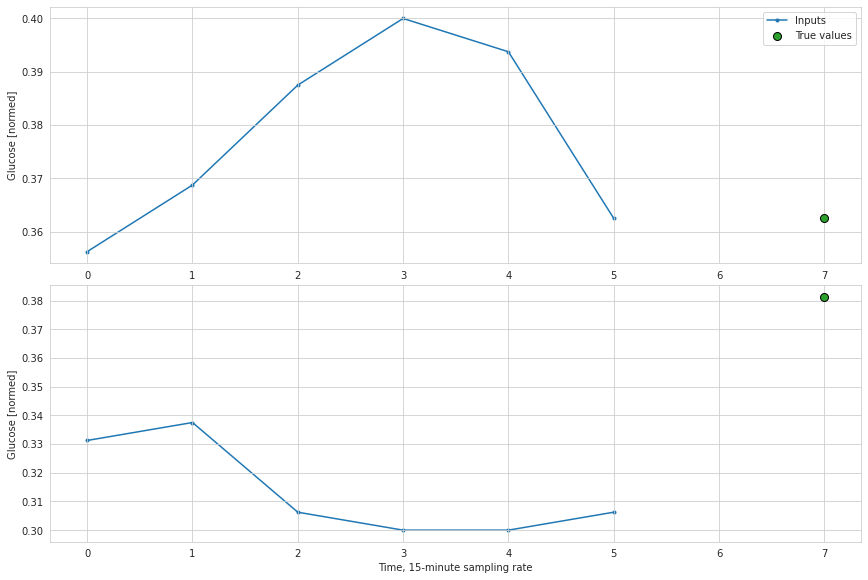

In [29]:
w.plot(max_subplots=2, save_file="prediction_example", label_title="True values")

## Evaluation setup

CEGA evaluation

In [29]:
def determine_zone(actual, pred):
    """
    Determines CEGA zone for given scatter point
    :param actual: Reference value
    :param pred: Predicted value
    :return: CEGA zone where the given scatter point should lay
    """
    #Zone A
    if (actual <= 70 and pred <= 70) or 1.2 * actual >= pred >= 0.8 * actual:
        return 0

    # Zone E - left upper
    if actual <= 70 and pred >= 180:
       return 4
    # Zone E - right lower
    if actual >= 180 and pred <= 70:
        return 4

    # Zone C - upper
    if 70 <= actual <= 290 and pred >= actual + 110:
        return 2
    # Zone C - lower
    if 130 <= actual <= 180 and pred <= (7/5) * actual - 182:
        return 2

    # Zone D - right
    if actual >= 240 and 70 <= pred <= 180:
        return 3
    # Zone D - left
    if actual <= 70 <= pred <= 180:
        return 3

    #Zone B
    else:
        return 1

def clarke_error_grid(ref_values, pred_values, title_string, save_file=None, plot=True):
    """
    Constructs a Clarke error grid plot and calculate zone statistics
    :param ref_values: Array of reference BG values
    :param pred_values: Array of predicted BG values
    :param title_string: Title for the plot
    :return: CEGA scatter plot and percentage of points within CEGA zones
    """
    assert len(ref_values) == len(pred_values), f"Got {len(ref_values)} reference values nad {len(pred_values)} predicted values, values must match."

    if ref_values and pred_values:
        assert max(ref_values) < 400 and max(pred_values) < 400, "Predicted or reference BG values are above valid range."
        assert min(ref_values) > 0 and min(pred_values) > 0, "Predicted or reference BG values are below valid range."

    # Clear
    fig = None
    if plot:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        ax.scatter(ref_values, pred_values, marker='o', color='black', s=8)
        ax.set_title(f"{title_string} Clarke Error Grid", fontsize=17)
        ax.set_xlabel("Reference Concentration [mg/dl]", fontsize=15)
        ax.set_ylabel("Prediction Concentration [mg/dl]", fontsize=15)
        ax.set_xticks([tick for tick in range(0, 400, 50)])
        ax.set_yticks([tick for tick in range(0, 400, 50)])
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_facecolor('white')

        #Set axes lengths
        ax.set_xlim([0, 400])
        ax.set_ylim([0, 400])
        ax.set_aspect(400 / 400)

        # Zone lines
        # Regression line
        ax.plot([0,400], [0,400], ':', c='black')

        # Zone A
        ax.plot([0, 175/3], [70, 70], '-', c='black')
        ax.plot([175/3, 400/1.2], [70, 400], '-', c='black')
        ax.plot([70, 70], [0, 56], '-', c='black')
        ax.plot([70, 400], [56, 320],'-', c='black')

        # Zone B
        ax.plot([70, 70], [0, 56], '-', c='black')

        ## Zone D and E
        ax.plot([70, 70], [84, 400],'-', c='black')
        ax.plot([0, 70], [180, 180], '-', c='black')
        # E
        ax.plot([180, 400], [70, 70], '-', c='black')
        # D
        ax.plot([240, 240], [70, 180],'-', c='black')
        ax.plot([240, 400], [180, 180], '-', c='black')

        # Zone C
        ax.plot([70, 290],[180, 400],'-', c='black')
        ax.plot([180, 180], [0, 70], '-', c='black')
        ax.plot([130, 180], [0, 70], '-', c='black')


        #Add zone titles
        zone_title_positions = {
            "A": [(30, 15), (360, 320), (320, 360)],
            "B": [(370, 260), (280, 370)],
            "C": [(160, 370), (160, 15)],
            "D": [(30, 140), (370, 120)],
            "E": [(30, 370), (370, 15)]
        }
        for zone, positions in zone_title_positions.items():
            for pos in positions:
                ax.text(pos[0], pos[1], zone, fontsize=15)

    # Calculate statistics
    zones = [0] * 5
    if ref_values and pred_values:
        for i in range(len(ref_values)):
            zones[determine_zone(ref_values[i], pred_values[i])] += 1
        total = sum(zones)
        # Get percentage
        zones = [zone / total for zone in zones]

    if save_file and plot:
        fig.tight_layout(pad=0.5)
        fig.savefig(fname=f"figures/model_evaluation/{save_file}.png")

    return fig, zones

(<Figure size 720x720 with 1 Axes>, [0, 0, 0, 0, 0])

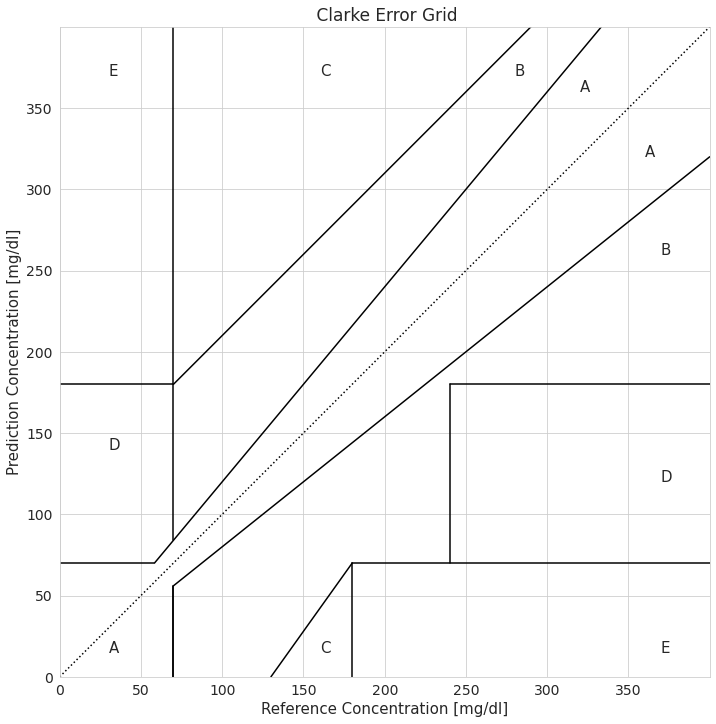

In [99]:
clarke_error_grid([], [], "", "cega_empty")

In [30]:
def get_cega_results(model, data_to_eval, store_in, store_as, plot=False, save_file=None):
    actual = []
    for _, y in data_to_eval:
        actual.extend([bg_denormalize(y) for y in y.numpy().flatten()])

    predicted = [bg_denormalize(y) for y in model.predict(data_to_eval).flatten()]

    _, results = clarke_error_grid(actual, predicted, store_as, plot=plot, save_file=save_file)
    store_in[store_as] = results

#### Initiate dictionary for storing results

In [280]:
val_performance = {}
performance = {}
cega_val_performance = {}
cega_performance = {}

PH_EXAMINED = [30, 60, 120]

## Baseline models

In [279]:
# Baseline returning the current BG value
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

3
0  gaps identified
2458 size before reduction
1736 size after reduction
55/55 [==============================] - 0s 1ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756
18  gaps identified
1187 size before reduction
826 size after reduction
5
0  gaps identified
2458 size before reduction
1308 size after reduction
41/41 [==============================] - 0s 770us/step - loss: 0.0108 - root_mean_squared_error: 0.1038
18  gaps identified
1187 size before reduction
618 size after reduction
9
0  gaps identified
2458 size before reduction
868 size after reduction
28/28 [==============================] - 0s 609us/step - loss: 0.0161 - root_mean_squared_error: 0.1267
18  gaps identified
1187 size before reduction
393 size after reduction


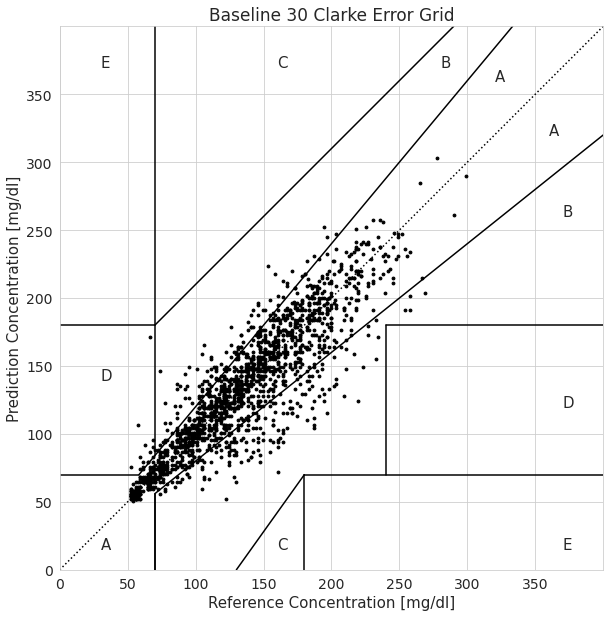

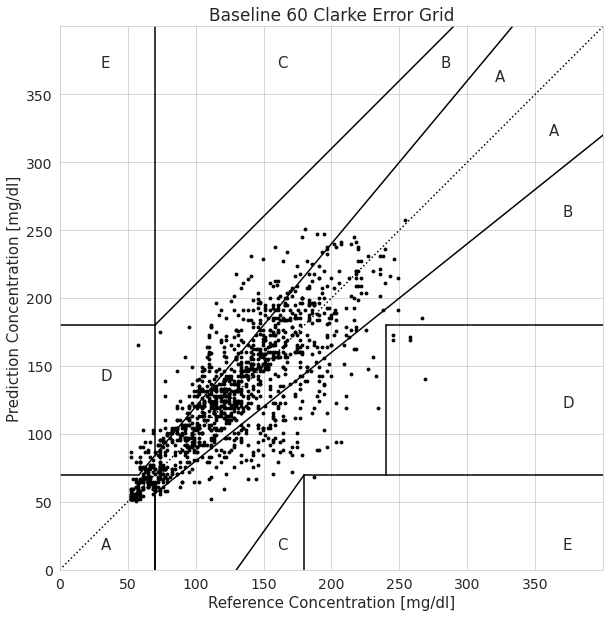

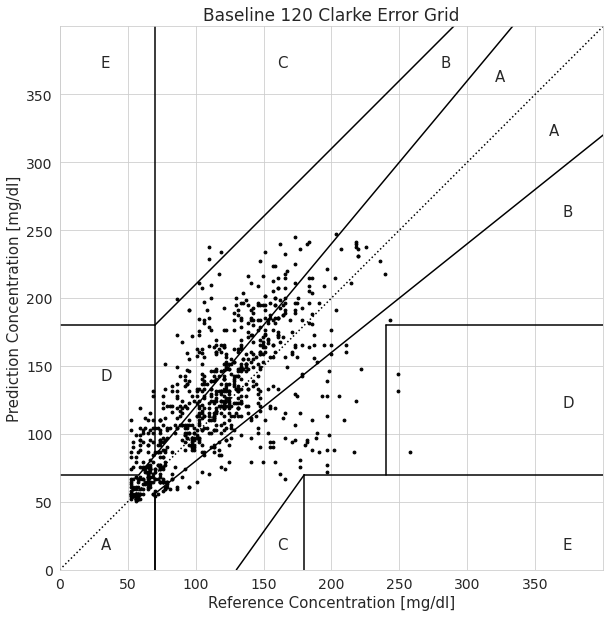

In [281]:
for ph in PH_EXAMINED:
    shift = ph // SAMPL_FREQ
    window = get_window(["Time", "Glucose"], 1, 1, shift, drop_noisy=True)
    print(window.total_window_size)
    baseline = Baseline(label_index=0)
    baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.RootMeanSquaredError()])
    val_performance[f'Baseline {ph}'] = baseline.evaluate(window.val)
    performance[f'Baseline {ph}'] = baseline.evaluate(window.test, verbose=0)
    get_cega_results(baseline, window.val, cega_val_performance, f"Baseline {ph}", plot=True)
    get_cega_results(baseline, window.test, cega_performance, f"Baseline {ph}", plot=False)

In [282]:
[print(f"{m}: {res}") for m, res in cega_performance.items()];

Baseline 30: [0.8341404358353511, 0.15617433414043583, 0.0, 0.009685230024213076, 0.0]
Baseline 60: [0.6601941747572816, 0.2961165048543689, 0.0048543689320388345, 0.03398058252427184, 0.0048543689320388345]
Baseline 120: [0.4402035623409669, 0.42493638676844786, 0.015267175572519083, 0.11704834605597965, 0.002544529262086514]


In [283]:
show_performance(performance, "mgdl")

Baseline 30 22.992557128906245
Baseline 60 33.11824348068237
Baseline 120 43.68865309906005


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Glucose']
0  gaps identified


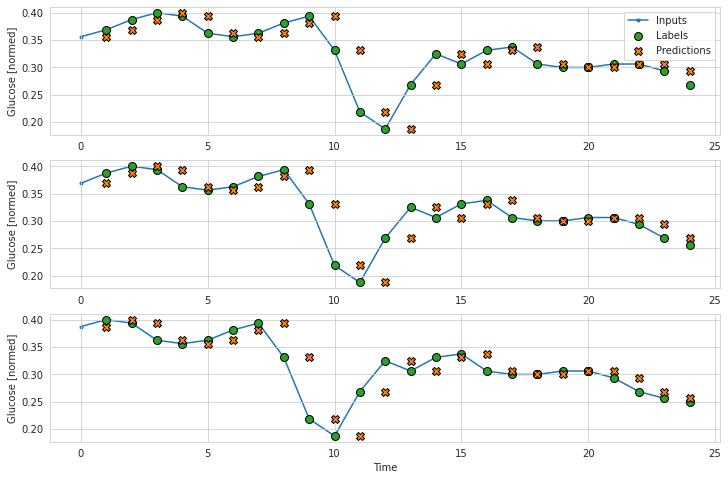

In [116]:
wide_window = get_window(["Time", "Glucose"], 24, 24, 1)
print(wide_window)
baseline = Baseline(label_index=0)
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.RootMeanSquaredError()])
wide_window.plot(baseline)

### Hyper-parameter tuning setup

In [461]:
import keras_tuner as kt

def build_dense_model(hp):
    """
    Builds FFNN model with the given hyperparameters
    :param hp: Hyperparameters
    :return: Compiled model with the given hyperparameters
    """
    model = keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 2
    # Number of Units: 8 - 48 with step-size of 8
    for i in range(1, hp.Int("num_layers", 2, 3)):
        model.add(
            layers.Dense(
                units=hp.Int("units_" + str(i), min_value=8, max_value=48, step=8),
                activation="relu"
            )
        )
        # Tune dropout layer with values from 0 to 0.15 with stepsize of 0.05
        model.add(tf.keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.15, step=0.05)))

    # Add output layer.
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Reshape([1, -1]))

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Define optimizer, loss, and metrics
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=[tf.metrics.RootMeanSquaredError()])
    return model

def build_lstm_model(hp):
    """
    Builds RNN LSTM model with the given hyperparameters
    :param hp: Hyperparameters
    :return: Compiled model with the given hyperparameters
    """

    model = keras.Sequential()

    # Number of Units: 16 - 64 with step-size of d
    model.add(tf.keras.layers.LSTM(hp.Int("units", min_value=12, max_value=60, step=4), return_sequences=False))

    # Tune dropout layer with values from 0 to 0.15 with stepsize of 0.05
    model.add(tf.keras.layers.Dropout(hp.Float("dropout", 0, 0.15, step=0.05)))

    # Add output layer
    model.add(tf.keras.layers.Dense(units=1))

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Define optimizer, loss, and metrics
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=[tf.metrics.RootMeanSquaredError()])
    return model

def tune_model(window, build_model_function, model_name, max_epochs=70, save=True, preprocess_fn=None):
    """
    Runs hyperparameter search using keras_tuner Hyperband
    :param window: Window to train on
    :param max_epochs: Maximum number of passing the training data through the model
    :return: tuner instance, best hyper-parameters, best model
    """

    # Instantiate the tuner
    tuner = kt.Hyperband(
        build_model_function,
        objective=kt.Objective("val_root_mean_squared_error", direction="min"),
        max_epochs=max_epochs,
        factor=3,
        hyperband_iterations=8,
        #directory="kt_dir",
        project_name=model_name,
    )
    print(tuner.search_space_summary())

    train, val = window.train, window.val
    if preprocess_fn:
        train = preprocess_fn(train)
        val = preprocess_fn(val)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    tuner.search(train, epochs=max_epochs, validation_data=val, callbacks=[early_stopping], verbose=2)

    best_hps = tuner.get_best_hyperparameters()[0]
    best_model = build_model_function(best_hps)

    if save:
        best_model.fit(train, epochs=max_epochs, validation_data=val, callbacks=[early_stopping])
        save_model(best_model, model_name)
    return tuner, best_hps, best_model

### Rapid Insulin IOB feature assessment
Here we look at the performance gained by using RIOB compared to raw insulin samples

In [359]:
using_columns = ["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"]
window = get_window(using_columns, [8, 0, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
history = compile_and_fit(model, window, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 2/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 3/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 5/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0

In [251]:
using_columns = ["Time", "Glucose", "Rapid Insulin", "Carbohydrates"]
window = get_window(using_columns, 20, 1, 4, drop_noisy=True, batch_size=16)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(lstm_model, window, max_epochs=60)

0  gaps identified
8602 size before reduction
5073 size after reduction
0  gaps identified
2458 size before reduction
1301 size after reduction
Epoch 1/60
318/318 [==============================] - 8s 13ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 2/60
318/318 [==============================] - 4s 12ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 3/60
318/318 [==============================] - 3s 10ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 4/60
318/318 [==============================] - 3s 11ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 5/60
318/318 [==============================] - 4s 13ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0093 - val_root_mean_squared_error

In [252]:
using_columns = ["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"]
window = get_window(using_columns, 20, 1, 4, drop_noisy=True, batch_size=16)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(lstm_model, window, max_epochs=60)

0  gaps identified
8602 size before reduction
5073 size after reduction
0  gaps identified
2458 size before reduction
1301 size after reduction
Epoch 1/60
318/318 [==============================] - 4s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 2/60
318/318 [==============================] - 2s 6ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/60
318/318 [==============================] - 2s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 4/60
318/318 [==============================] - 2s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 5/60
318/318 [==============================] - 2s 7ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0

Overall seems like using RIOB brings us around 3% better accuracy.

### Glycemic load assessment
Here we look at the performance gained by using glycemic load compared to raw carbohydrates samples in dense models

In [357]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Glycemic Load"],
                    [8, 0, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 2/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 3/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 4/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 5/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0

In [358]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"],
                    [8, 0, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 1ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 2/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0880
Epoch 3/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 5/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0

Using Carbohydrates seems like a better option when looking at val_root_mean_squared_error

### Long insulin, 6d mean insulin, calories and hour assessment

In [360]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"],
                    [8, 0, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 2/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882
Epoch 3/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 4/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 5/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0

In [361]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Long Insulin"],
                    [8, 0, 8, 1], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 2/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 3/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 4/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 5/60
318/318 [==============================] - 0s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0

In [362]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Rapid Insulin 6d"],
                    [8, 0, 8, 1], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 2/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 3/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 4/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 5/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0

In [363]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour"],
                    [8, 0, 8, 1], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 2/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 3/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 4/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 5/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0

In [365]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "calories"],
                    [8, 0, 8, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 1ms/step - loss: 0.0235 - root_mean_squared_error: 0.1531 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 2/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 3/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 4/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 5/60
318/318 [==============================] - 0s 1ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0

In [368]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "distance"],
                    [8, 0, 8, 8], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
m = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
compile_and_fit(m, w, max_epochs=60)

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024
Epoch 2/60
318/318 [==============================] - 0s 2ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 3/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 4/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 5/60
318/318 [==============================] - 1s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0

## Finding optimal models

### FFNN models

#### 2 hour prediction

In [370]:
# 2h of BG, 2h look-ahead RIOB, 2h of Carbohydrates, and 1 sample of hour and long insulin
# predict with PH 2h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 8, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 8)])
model_name = f"ffnn_2h_{'_'.join([col for col in w.train_df.columns])}"
tuner_ffnn_2h, hps_ffnn_2h, best_ffnn_2h = tune_model(w, build_dense_model, model_name)

Trial 720 Complete [00h 00m 17s]
val_root_mean_squared_error: 0.08266927301883698

Best val_root_mean_squared_error So Far: 0.07940138876438141
Total elapsed time: 01h 17m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
217/217 [==============================] - 1s 2ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 2/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 3/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 4/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 5/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 6/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0073 - val_

INFO:tensorflow:Assets written to: models/ffnn_2h_Glucose_Rapid Insulin IOB_Carbohydrates_Hour_Long Insulin/assets


In [371]:
hps_ffnn_2h.values

{'num_layers': 3,
 'units_1': 40,
 'dropout_1': 0.05,
 'learning_rate': 0.001,
 'units_2': 24,
 'dropout_2': 0.1,
 'tuner/epochs': 24,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

#### 1 hour prediction

In [382]:
# 2h of BG, 1h look-ahead RIOB, 2h of Carbohydrates, and 1 sample of hour and long insulin
# predict with PH 2h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
model_name = f"ffnn_1h_{'_'.join([col for col in w.train_df.columns])}"
tuner_ffnn_1h, hps_ffnn_1h, best_ffnn_1h = tune_model(w, build_dense_model, model_name)

Trial 720 Complete [00h 00m 37s]
val_root_mean_squared_error: 0.07430927455425262

Best val_root_mean_squared_error So Far: 0.07181207835674286
Total elapsed time: 02h 07m 41s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
318/318 [==============================] - 1s 2ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 2/70
318/318 [==============================] - 1s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 3/70
318/318 [==============================] - 1s 2ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 4/70
318/318 [==============================] - 0s 1ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 5/70
318/318 [==============================] - 0s 1ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 6/70
318/318 [==============================] - 0s 1ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0062 - val_

INFO:tensorflow:Assets written to: models/ffnn_1h_Glucose_Rapid Insulin IOB_Carbohydrates_Hour_Long Insulin/assets


In [383]:
hps_ffnn_1h.values

{'num_layers': 3,
 'units_1': 48,
 'dropout_1': 0.0,
 'learning_rate': 0.001,
 'units_2': 8,
 'dropout_2': 0.0,
 'tuner/epochs': 70,
 'tuner/initial_epoch': 24,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0406'}

#### 30 minute prediction

In [388]:
# 2h of BG, 1h look-ahead RIOB, 2h of Carbohydrates, and 1 sample of hour and long insulin
# predict with PH 2h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 2, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 2)])
model_name = f"ffnn_30min_{'_'.join([col for col in w.train_df.columns])}"
tuner_ffnn_30min, hps_ffnn_30min, best_ffnn_30min = tune_model(w, build_dense_model, model_name)

Trial 255 Complete [00h 00m 19s]
val_root_mean_squared_error: 0.06203196570277214

Best val_root_mean_squared_error So Far: 0.058130715042352676
Total elapsed time: 00h 48m 01s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
403/403 [==============================] - 2s 2ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 2/70
403/403 [==============================] - 0s 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 3/70
403/403 [==============================] - 0s 1ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 4/70
403/403 [==============================] - 0s 1ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 5/70
403/403 [==============================] - 0s 1ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 6/70
403/403 [==============================] - 0s 1ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0037 - val_

INFO:tensorflow:Assets written to: models/ffnn_30min_Glucose_Rapid Insulin IOB_Carbohydrates_Hour_Long Insulin/assets


In [389]:
hps_ffnn_30min.values

{'num_layers': 2,
 'units_1': 40,
 'learning_rate': 0.001,
 'units_2': 32,
 'tuner/epochs': 70,
 'tuner/initial_epoch': 24,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0139'}

### LSTM models

#### 2 hour prediction

In [333]:
# 20 previous values -> 5 hours, predict with PH 2h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 8, drop_noisy=True, batch_size=16)
model_name = f"lstm_2h_{'_'.join([col for col in w.train_df.columns])}"
tuner_lstm_2h, hps_lstm_2h, best_lstm_2h = tune_model(w, build_lstm_model, model_name)

Trial 194 Complete [00h 00m 06s]
val_root_mean_squared_error: 0.12347286939620972

Best val_root_mean_squared_error So Far: 0.08290629833936691
Total elapsed time: 00h 48m 54s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
216/216 [==============================] - 4s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 2/70
216/216 [==============================] - 2s 7ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 3/70
216/216 [==============================] - 1s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 4/70
216/216 [==============================] - 2s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 5/70
216/216 [==============================] - 1s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 6/70
216/216 [==============================] - 2s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0078 - val_

INFO:tensorflow:Assets written to: models/lstm_2h_Glucose_Rapid Insulin IOB_Carbohydrates/assets


INFO:tensorflow:Assets written to: models/lstm_2h_Glucose_Rapid Insulin IOB_Carbohydrates/assets


In [320]:
# 20 previous values -> 5 hours, predict with PH 2h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "calories"], 20, 1, 8, drop_noisy=True, batch_size=16)
model_name = f"lstm_2h_{'_'.join([col for col in w.train_df.columns])}"
tuner_lstm_2h_w_calories, hps_lstm_2h_w_calories, best_lstm_2h_w_calories = tune_model(w, build_lstm_model, model_name)

Trial 154 Complete [00h 00m 14s]
val_root_mean_squared_error: 0.0960972011089325

Best val_root_mean_squared_error So Far: 0.08427946269512177
Total elapsed time: 00h 36m 33s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
216/216 [==============================] - 4s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 2/70
216/216 [==============================] - 2s 9ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 3/70
216/216 [==============================] - 2s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 4/70
216/216 [==============================] - 1s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 5/70
216/216 [==============================] - 2s 8ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 6/70
216/216 [==============================] - 2s 8ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0081 - val_

INFO:tensorflow:Assets written to: models/lstm_2h_Glucose_Rapid Insulin IOB_Carbohydrates_calories/assets


INFO:tensorflow:Assets written to: models/lstm_2h_Glucose_Rapid Insulin IOB_Carbohydrates_calories/assets


In [348]:
hps_lstm_2h.values

{'units': 56,
 'dropout': 0.05,
 'learning_rate': 0.01,
 'tuner/epochs': 70,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [335]:
w_c = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "calories"], 20, 1, 8, drop_noisy=True, batch_size=16)
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 8, drop_noisy=True, batch_size=16)
print(best_lstm_2h_w_calories.evaluate(w_c.val))
print(best_lstm_2h.evaluate(w.val))

0  gaps identified
2458 size before reduction
868 size after reduction
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870
[0.007573879323899746, 0.08702803403139114]
0  gaps identified
2458 size before reduction
868 size after reduction
55/55 [==============================] - 0s 2ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861
[0.00741646159440279, 0.08611887693405151]


Seems like we perform better without the calories data, for further models we will train without calories

#### 1 hour prediction

In [338]:
# 20 previous values -> 5 hours, predict with PH 1h
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 4, drop_noisy=True, batch_size=16)
model_name = f"lstm_1h_{'_'.join([col for col in w.train_df.columns])}"
tuner_lstm_1h, hps_lstm_1h, best_lstm_1h = tune_model(w, build_lstm_model, model_name)

Trial 192 Complete [00h 00m 10s]
val_root_mean_squared_error: 0.09008853137493134

Best val_root_mean_squared_error So Far: 0.07120512425899506
Total elapsed time: 01h 20m 44s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
318/318 [==============================] - 5s 9ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 2/70
318/318 [==============================] - 4s 12ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 3/70
318/318 [==============================] - 4s 12ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 4/70
318/318 [==============================] - 3s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 5/70
318/318 [==============================] - 3s 10ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 6/70
318/318 [==============================] - 3s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0056 - 

INFO:tensorflow:Assets written to: models/lstm_1h_Glucose_Rapid Insulin IOB_Carbohydrates/assets


INFO:tensorflow:Assets written to: models/lstm_1h_Glucose_Rapid Insulin IOB_Carbohydrates/assets


In [349]:
hps_lstm_1h.values

{'units': 32,
 'dropout': 0.0,
 'learning_rate': 0.01,
 'tuner/epochs': 70,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

#### 30 minutes prediction

In [350]:
# 20 previous values -> 5 hours, predict with PH 30min
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 2, drop_noisy=True, batch_size=16)
model_name = f"lstm_30min_{'_'.join([col for col in w.train_df.columns])}"
tuner_lstm_30min, hps_lstm_30min, best_lstm_30min = tune_model(w, build_lstm_model, model_name)

Trial 181 Complete [00h 00m 09s]
val_root_mean_squared_error: 0.11736887693405151

Best val_root_mean_squared_error So Far: 0.05518190935254097
Total elapsed time: 01h 13m 21s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/70
402/402 [==============================] - 5s 7ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 2/70
402/402 [==============================] - 2s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 3/70
402/402 [==============================] - 2s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 4/70
402/402 [==============================] - 3s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 5/70
402/402 [==============================] - 2s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 6/70
402/402 [==============================] - 3s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0043 - val_

INFO:tensorflow:Assets written to: models/lstm_30min_Glucose_Rapid Insulin IOB_Carbohydrates/assets


INFO:tensorflow:Assets written to: models/lstm_30min_Glucose_Rapid Insulin IOB_Carbohydrates/assets


In [351]:
hps_lstm_30min.values

{'units': 32,
 'dropout': 0.15000000000000002,
 'learning_rate': 0.001,
 'tuner/epochs': 70,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### SVM models

In [93]:
import sklearn
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from joblib import dump, load

#### Hyper-parameter tuning setup for svm

In [91]:
def find_best_params_svm(param_grid, window):
    param_gr = ParameterGrid(param_grid)

    x_train, y_train = get_flat_arrays(window.train)
    x_val, y_val = get_flat_arrays(window.val)

    val_metric = []
    for pars in param_gr:
        regr = svm.SVR(C=pars["C"], gamma=pars["gamma"], kernel=pars["kernel"], epsilon=pars["epsilon"])
        regr.fit(x_train, y_train)
        val_metric.append(math.sqrt(mean_squared_error(regr.predict(x_val), y_val)))

    best_params = param_gr[np.argmin(val_metric)]
    print(f"Found best params {best_params} with val RMSE {min(val_metric):.4f}.")

    best_svm = svm.SVR(C=best_params["C"], gamma=best_params["gamma"], kernel=best_params["kernel"], epsilon=best_params["epsilon"])
    best_svm.fit(x_train, y_train)
    return (
        best_svm,
        best_params
    )

In [95]:
tuned_svm_parameters = [{
    "kernel": ["rbf"],
    'C': [c for c in range(1, 20, 5)],
    'gamma': np.logspace(-4, 0, 8),
    "epsilon":[e / 100 for e in range(2, 10)]
}]

#### 2 hour prediction

In [487]:
window =  get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 8, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 8)])
svm_2h, svm_params_2h = find_best_params_svm(tuned_svm_parameters, window)

0  gaps identified
8602 size before reduction
3466 size after reduction
0  gaps identified
2458 size before reduction
868 size after reduction
0  gaps identified
11060 size before reduction
4337 size after reduction
Found best params {'kernel': 'rbf', 'gamma': 1.0, 'epsilon': 0.06, 'C': 1} with val RMSE 0.0809.


In [497]:
dump(svm_2h, os.path.join("models", "svm_2h.joblib"))

['models/svm_2h.joblib']

#### 1 hour prediction

In [498]:
window =  get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 4, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 4)])
svm_1h, svm_params_1h = find_best_params_svm(tuned_svm_parameters, window)
dump(svm_1h, os.path.join("models", "svm_1h.joblib"))

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
0  gaps identified
11060 size before reduction
6396 size after reduction
Found best params {'kernel': 'rbf', 'gamma': 1.0, 'epsilon': 0.02, 'C': 1} with val RMSE 0.0716.


['models/svm_1h.joblib']

In [499]:
window =  get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 2, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 2)])
svm_30min, svm_params_30min = find_best_params_svm(tuned_svm_parameters, window)
dump(svm_30min, os.path.join("models", "svm_30min.joblib"))

0  gaps identified
8602 size before reduction
6434 size after reduction
0  gaps identified
2458 size before reduction
1731 size after reduction
0  gaps identified
11060 size before reduction
8172 size after reduction
Found best params {'kernel': 'rbf', 'gamma': 0.2682695795279725, 'epsilon': 0.02, 'C': 1} with val RMSE 0.0564.


['models/svm_30min.joblib']

## Model Evaluation on test dataset

#### FFNN

0  gaps identified
8602 size before reduction
3466 size after reduction
0  gaps identified
2458 size before reduction
868 size after reduction
Epoch 1/70
217/217 [==============================] - 1s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 2/70
217/217 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 3/70
217/217 [==============================] - 1s 2ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 4/70
217/217 [==============================] - 1s 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 5/70
217/217 [==============================] - 0s 2ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0074 - val_root_mean_squared_error: 0.08

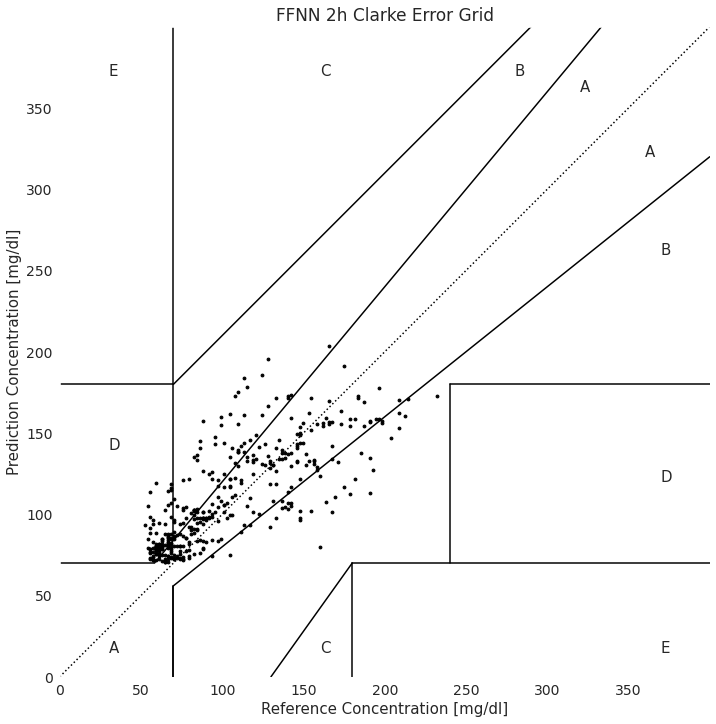

In [524]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 8, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 8)])
ffnn_2h_final = build_dense_model(hps_ffnn_2h)
model_fit(ffnn_2h_final, w, max_epochs=70)
performance['FFNN 2h'] = ffnn_2h_final.evaluate(w.test, verbose=0)
get_cega_results(ffnn_2h_final, w.test, cega_performance, f"FFNN 2h", plot=True, save_file="ffnn_2h_cega")

0  gaps identified
8602 size before reduction
5085 size after reduction
0  gaps identified
2458 size before reduction
1305 size after reduction
Epoch 1/70
318/318 [==============================] - 2s 4ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 2/70
318/318 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 3/70
318/318 [==============================] - 0s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 4/70
318/318 [==============================] - 1s 2ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 5/70
318/318 [==============================] - 1s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0

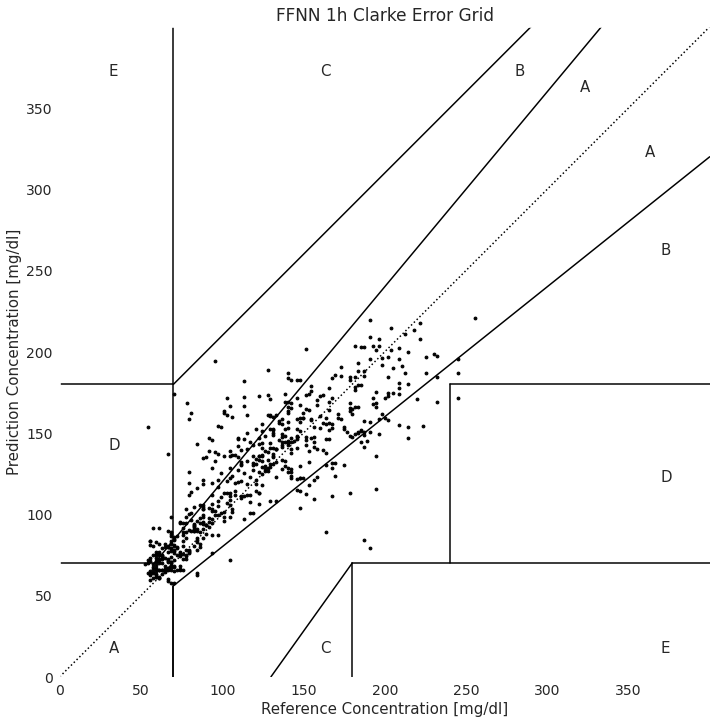

In [525]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 4, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 4)])
ffnn_1h_final = build_dense_model(hps_ffnn_1h)
model_fit(ffnn_1h_final, w, max_epochs=70)
performance['FFNN 1h'] = ffnn_1h_final.evaluate(w.test, verbose=0)
get_cega_results(ffnn_1h_final, w.test, cega_performance, f"FFNN 1h", plot=True, save_file="ffnn_1h_cega")

0  gaps identified
8602 size before reduction
6434 size after reduction
0  gaps identified
2458 size before reduction
1731 size after reduction
Epoch 1/70
403/403 [==============================] - 1s 2ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0745
Epoch 2/70
403/403 [==============================] - 1s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 3/70
403/403 [==============================] - 1s 2ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 4/70
403/403 [==============================] - 1s 2ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 5/70
403/403 [==============================] - 1s 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0

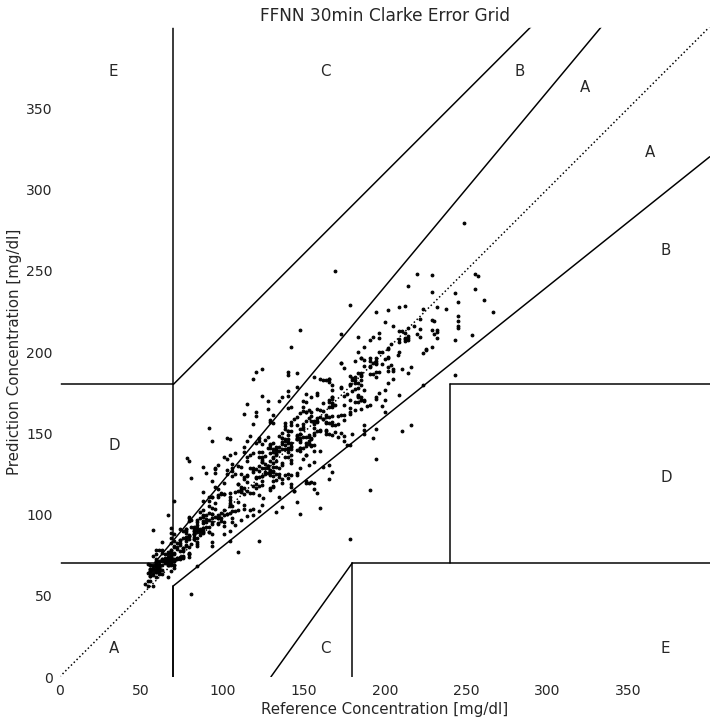

In [526]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 2, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 2)])
ffnn_30min_final = build_dense_model(hps_ffnn_30min)
model_fit(ffnn_30min_final, w, max_epochs=70)
performance['FFNN 30min'] = ffnn_30min_final.evaluate(w.test, verbose=0)
get_cega_results(ffnn_30min_final, w.test, cega_performance, f"FFNN 30min", plot=True, save_file="ffnn_30min_cega")

#### LSTM

0  gaps identified
8602 size before reduction
3454 size after reduction
0  gaps identified
2458 size before reduction
868 size after reduction
Epoch 1/70
216/216 [==============================] - 5s 13ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 2/70
216/216 [==============================] - 3s 15ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 3/70
216/216 [==============================] - 3s 13ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 4/70
216/216 [==============================] - 2s 10ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 5/70
216/216 [==============================] - 3s 12ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0080 - val_root_mean_squared_error:

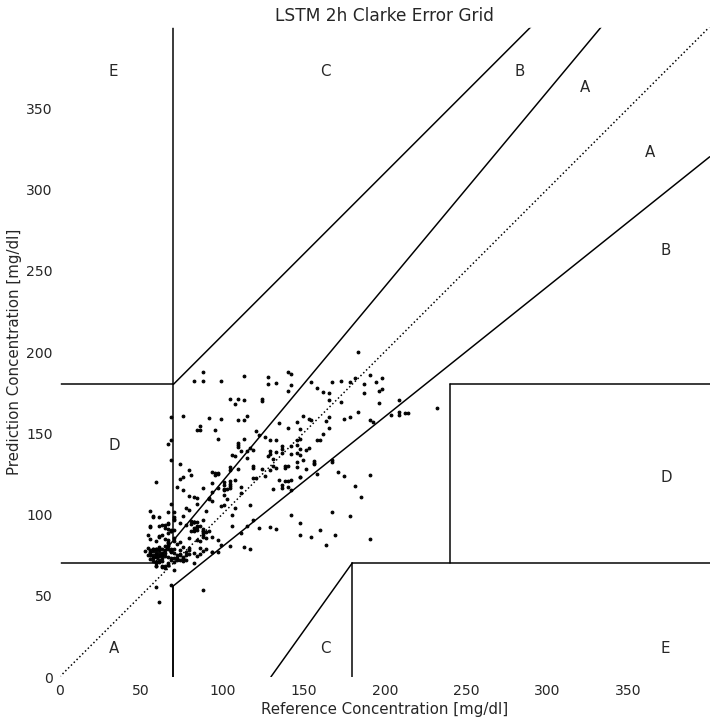

In [527]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 8, drop_noisy=True, batch_size=16)
lstm_2h_final = build_lstm_model(hps_lstm_2h)
model_fit(lstm_2h_final, w, max_epochs=70)
performance['LSTM 2h'] = lstm_2h_final.evaluate(w.test, verbose=0)
get_cega_results(lstm_2h_final, w.test, cega_performance, f"LSTM 2h", plot=True, save_file="lstm_2h_cega")

0  gaps identified
8602 size before reduction
5073 size after reduction
0  gaps identified
2458 size before reduction
1301 size after reduction
Epoch 1/70
318/318 [==============================] - 5s 10ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 2/70
318/318 [==============================] - 3s 9ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 3/70
318/318 [==============================] - 3s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 4/70
318/318 [==============================] - 3s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 5/70
318/318 [==============================] - 3s 9ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0057 - val_root_mean_squared_error: 0

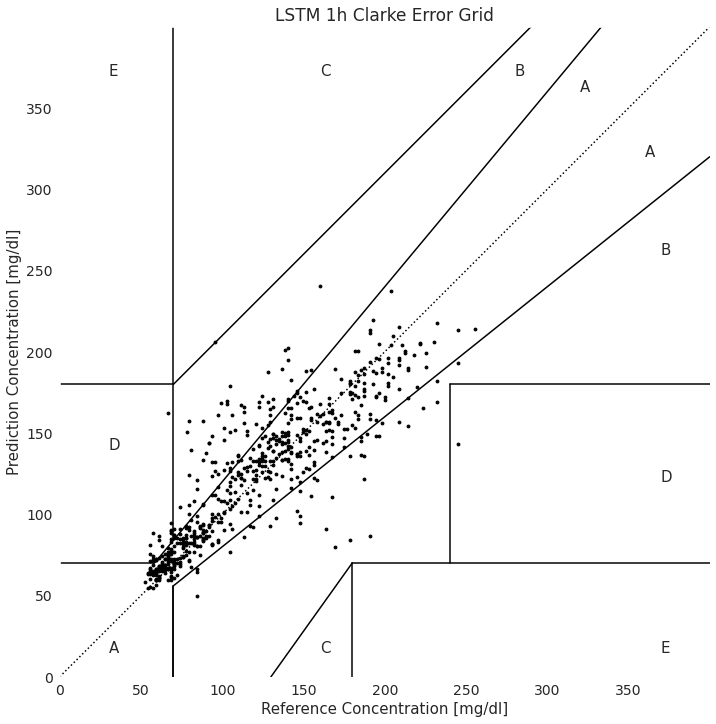

In [528]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 4, drop_noisy=True, batch_size=16)
lstm_1h_final = build_lstm_model(hps_lstm_1h)
model_fit(lstm_1h_final, w, max_epochs=70)
performance['LSTM 1h'] = lstm_1h_final.evaluate(w.test, verbose=0)
get_cega_results(lstm_1h_final, w.test, cega_performance, f"LSTM 1h", plot=True, save_file="lstm_1h_cega")

0  gaps identified
8602 size before reduction
6422 size after reduction
0  gaps identified
2458 size before reduction
1724 size after reduction
Epoch 1/70
402/402 [==============================] - 7s 12ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 2/70
402/402 [==============================] - 4s 10ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754
Epoch 3/70
402/402 [==============================] - 4s 10ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 4/70
402/402 [==============================] - 4s 10ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 5/70
402/402 [==============================] - 4s 10ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0043 - val_root_mean_squared_error

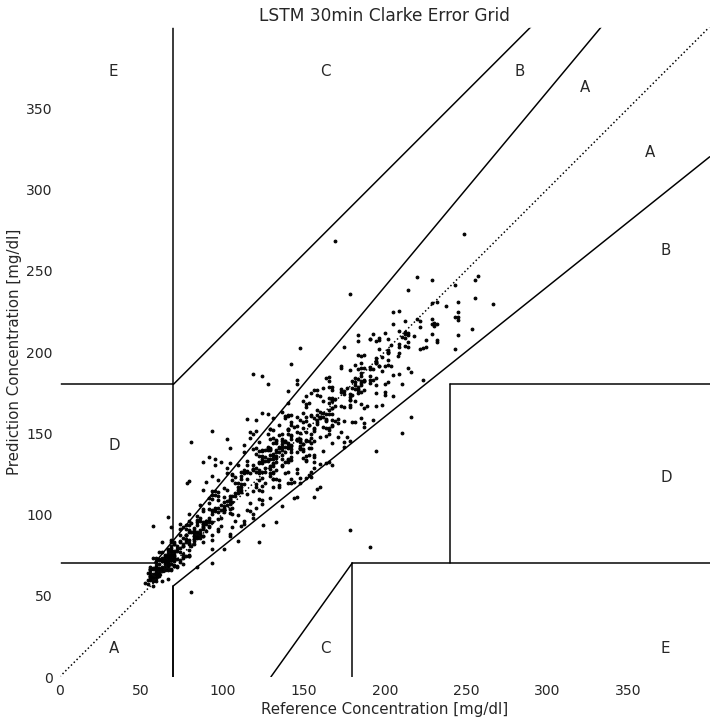

In [529]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 2, drop_noisy=True, batch_size=16)
lstm_30min_final = build_lstm_model(hps_lstm_30min)
model_fit(lstm_30min_final, w, max_epochs=70)
performance['LSTM 30min'] = lstm_30min_final.evaluate(w.test, verbose=0)
get_cega_results(lstm_30min_final, w.test, cega_performance, f"LSTM 30min", plot=True, save_file="lstm_30min_cega")

### ANN-based overall results

In [561]:
show_performance(performance, "mgdl")

Baseline 30 22.992557128906245
Baseline 60 33.11824348068237
Baseline 120 43.68865309906005
FFNN 2h 27.112007408142084
FFNN 1h 25.51925544357299
FFNN 30min 18.263532379150384
LSTM 2h 30.202036464691155
LSTM 1h 24.319351814270014
LSTM 30min 17.06323357772827


In [543]:
[print(f"{m}: {res}") for m, res in cega_performance.items() if any(("FFNN" in m, "LSTM" in m))];

FFNN 2h: [0.5166240409207161, 0.27365728900255754, 0.0, 0.20971867007672634, 0.0]
FFNN 1h: [0.7320261437908496, 0.2107843137254902, 0.0, 0.05718954248366013, 0.0]
FFNN 30min: [0.8681318681318682, 0.115995115995116, 0.0, 0.015873015873015872, 0.0]
LSTM 2h: [0.5549872122762148, 0.26854219948849106, 0.0, 0.17647058823529413, 0.0]
LSTM 1h: [0.7766830870279147, 0.18555008210180624, 0.0016420361247947454, 0.0361247947454844, 0.0]
LSTM 30min: [0.9014778325123153, 0.08497536945812807, 0.0, 0.013546798029556651, 0.0]


#### SVM

In [535]:
svm_performance = {}

def get_cega_results_svm(model, x, y, store_in, store_as, plot=False, save_file=None):
    actual = [bg_denormalize(y) for y in y]

    predicted = [bg_denormalize(y) for y in model.predict(x).flatten()]

    _, results = clarke_error_grid(actual, predicted, store_as, plot=plot, save_file=save_file)
    store_in[store_as] = results

0  gaps identified
8602 size before reduction
3466 size after reduction
18  gaps identified
1187 size before reduction
391 size after reduction


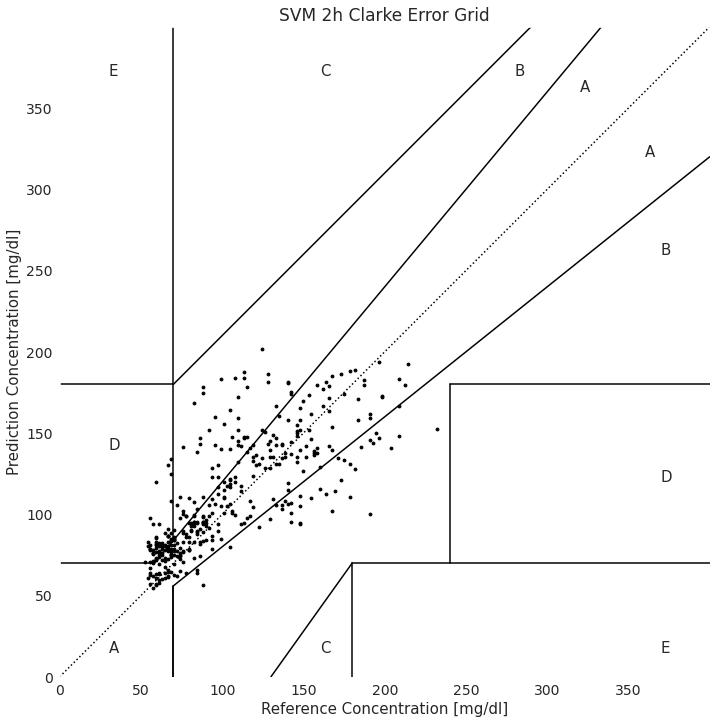

In [537]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 8, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 8)])
x_train, y_train = get_flat_arrays(w.train)
x_test, y_test = get_flat_arrays(w.test)

svm_2h_final = svm.SVR(C=svm_params_2h["C"], gamma=svm_params_2h["gamma"], kernel=svm_params_2h["kernel"], epsilon=svm_params_2h["epsilon"])
svm_2h_final.fit(x_train, y_train)

svm_performance["SVM 2h"] = [math.sqrt(mean_squared_error(svm_2h_final.predict(x_test), y_test))]
get_cega_results_svm(svm_2h_final, x_test, y_test, cega_performance, f"SVM 2h", plot=True, save_file="svm_2h_cega")

0  gaps identified
8602 size before reduction
5085 size after reduction
18  gaps identified
1187 size before reduction
612 size after reduction


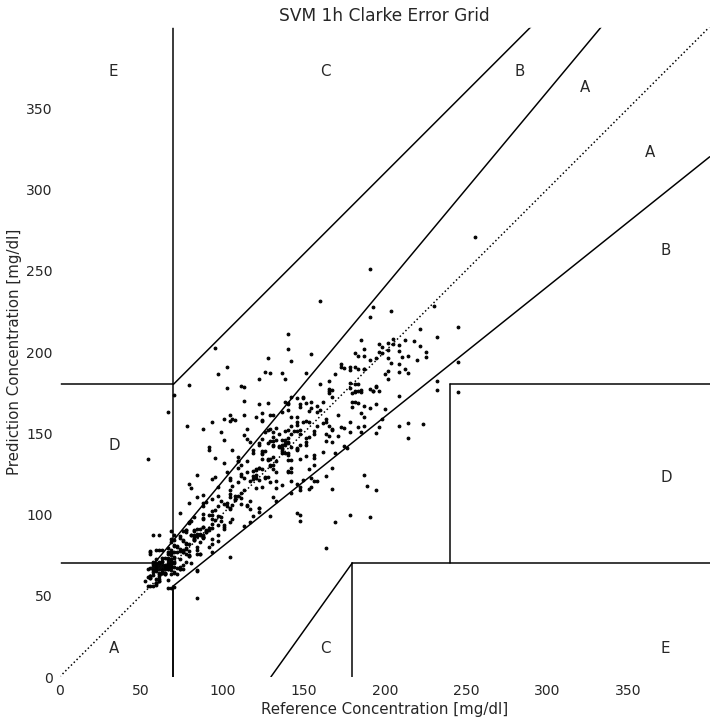

In [541]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 4, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 4)])
x_train, y_train = get_flat_arrays(w.train)
x_test, y_test = get_flat_arrays(w.test)

svm_1h_final = svm.SVR(C=svm_params_1h["C"], gamma=svm_params_1h["gamma"], kernel=svm_params_1h["kernel"], epsilon=svm_params_1h["epsilon"])
svm_1h_final.fit(x_train, y_train)

svm_performance["SVM 1h"] = [math.sqrt(mean_squared_error(svm_1h_final.predict(x_test), y_test))]
get_cega_results_svm(svm_1h_final, x_test, y_test, cega_performance, f"SVM 1h", plot=True, save_file="svm_1h_cega")

0  gaps identified
8602 size before reduction
6434 size after reduction
18  gaps identified
1187 size before reduction
819 size after reduction


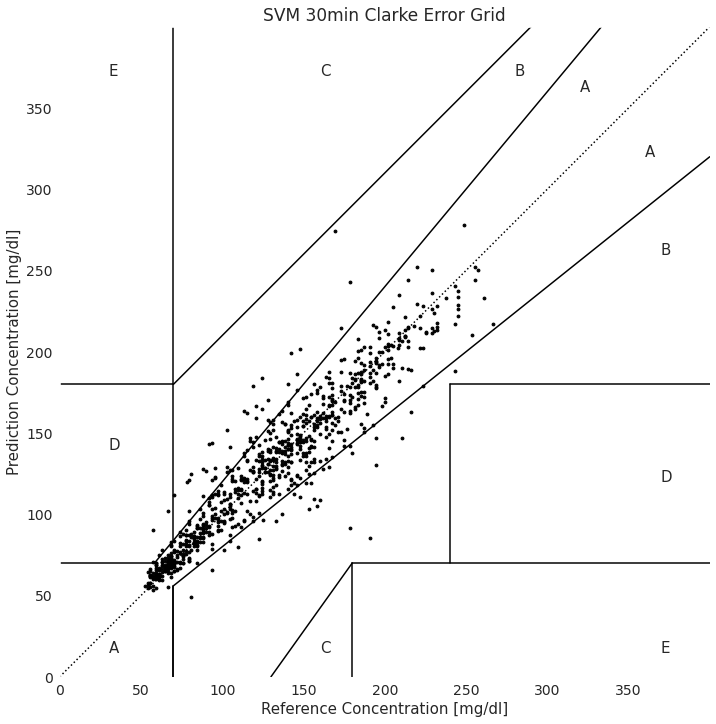

In [542]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates", "Hour", "Long Insulin"],
                    [8, 0, 8, 1, 1], 1, 2, drop_noisy=True, batch_size=1, look_ahead_columns=[("Rapid Insulin IOB", 2)])
x_train, y_train = get_flat_arrays(w.train)
x_test, y_test = get_flat_arrays(w.test)

svm_30min_final = svm.SVR(C=svm_params_30min["C"], gamma=svm_params_30min["gamma"], kernel=svm_params_30min["kernel"], epsilon=svm_params_30min["epsilon"])
svm_30min_final.fit(x_train, y_train)

svm_performance["SVM 30min"] = [math.sqrt(mean_squared_error(svm_30min_final.predict(x_test), y_test))]
get_cega_results_svm(svm_30min_final, x_test, y_test, cega_performance, f"SVM 30min", plot=True, save_file="svm_30min_cega")

In [565]:
# Adjustment so it matches performance format reported by ANN-models
svm_performance = {k: [0, v[0]] for k, v in svm_performance.items()}

In [567]:
show_performance(svm_performance, "mgdl")

SVM 2h 27.47524349316086
SVM 1h 24.908451002740662
SVM 30min 17.41449449889417


In [544]:
[print(f"{m}: {res}") for m, res in cega_performance.items() if "SVM" in m];

SVM 2h: [0.5959079283887468, 0.2506393861892583, 0.0, 0.1534526854219949, 0.0]
SVM 1h: [0.8006535947712419, 0.17320261437908496, 0.0, 0.026143790849673203, 0.0]
SVM 30min: [0.9010989010989011, 0.09157509157509157, 0.0, 0.007326007326007326, 0.0]


### Plots for visual evaluation

In [30]:
lstm_2h_final = tf.keras.models.load_model("models/lstm_2h_Glucose_Rapid Insulin IOB_Carbohydrates")

In [31]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 8, drop_noisy=True, batch_size=16)

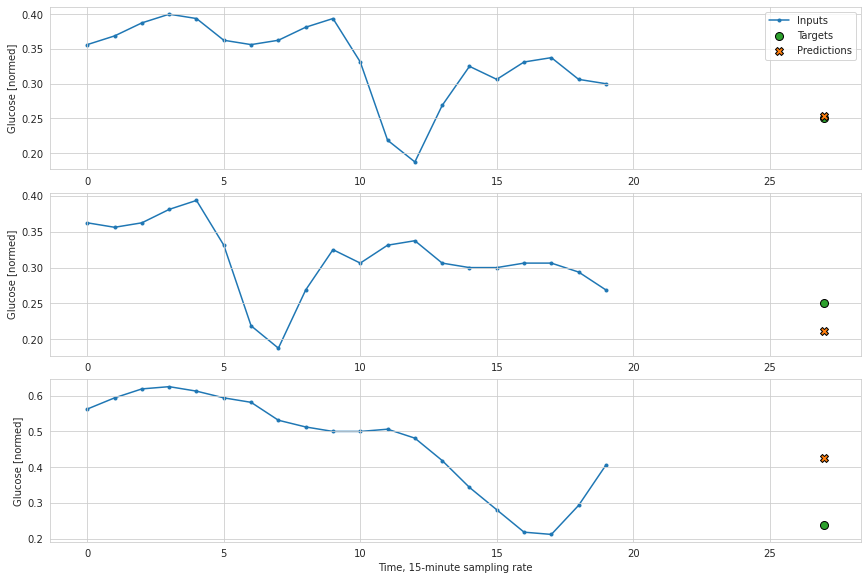

In [33]:
w.plot(lstm_2h_final, save_file="lstm_2h_plot")

In [34]:
lstm_30min_final = tf.keras.models.load_model("models/lstm_30min_Glucose_Rapid Insulin IOB_Carbohydrates")

In [35]:
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 1, 2, drop_noisy=True, batch_size=16)
dat_iter = iter(w.train)
data_examples = [next(dat_iter) for _ in range(10)]
inputs, labels = data_examples[1]

0  gaps identified
8602 size before reduction
6422 size after reduction


In [36]:
lstm_predictions = lstm_30min_final.predict(inputs)

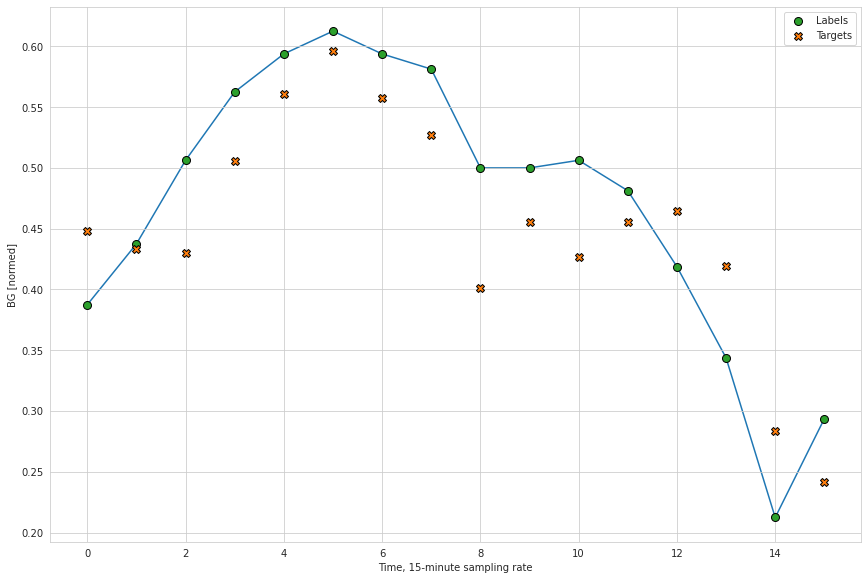

In [38]:
indices = [x for x in range(len(lstm_predictions))]
plt.figure(figsize=(12, 8))

plt.ylabel(f'BG [normed]')
#plt.plot(inputs, label='Inputs', marker='.', zorder=-10)

plt.scatter(indices, labels.numpy().flatten(), edgecolors='k', label='Labels', c='#2ca02c', s=64)
plt.plot(indices, labels.numpy().flatten(), marker='.', zorder=-10)

plt.scatter(
    indices, lstm_predictions, marker='X', edgecolors='k', label='Targets', c='#ff7f0e', s=64
)

plt.legend()
plt.xlabel('Time, 15-minute sampling rate')

plt.tight_layout(pad=0.5)
plt.savefig(fname=f"figures/prediction_behavior_lstm_30min.png")

## Multi output predictions

In [39]:
#w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"],
#                    [8, 0, 8, 1, 1], 8, 8, drop_noisy=True, batch_size=16, look_ahead_columns=[("Rapid Insulin IOB", 8)])
w = get_window(["Time", "Glucose", "Rapid Insulin IOB", "Carbohydrates"], 20, 8, 8, drop_noisy=True, batch_size=16)

model_multi_output = tf.keras.Sequential([
    tf.keras.layers.LSTM(56, return_sequences=False),
    tf.keras.layers.Dropout(0.05),
    # 8 outputs -> 2 hours of future BG values
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Reshape([8, -1]),
])
compile_and_fit(model_multi_output, w, max_epochs=70)

0  gaps identified
8602 size before reduction
3454 size after reduction
0  gaps identified
2458 size before reduction
868 size after reduction
Epoch 1/70
216/216 [==============================] - 3s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1286 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 2/70
216/216 [==============================] - 2s 9ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 3/70
216/216 [==============================] - 2s 9ms/step - loss: 0.0088 - root_mean_squared_error: 0.0941 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 4/70
216/216 [==============================] - 2s 9ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 5/70
216/216 [==============================] - 2s 10ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0

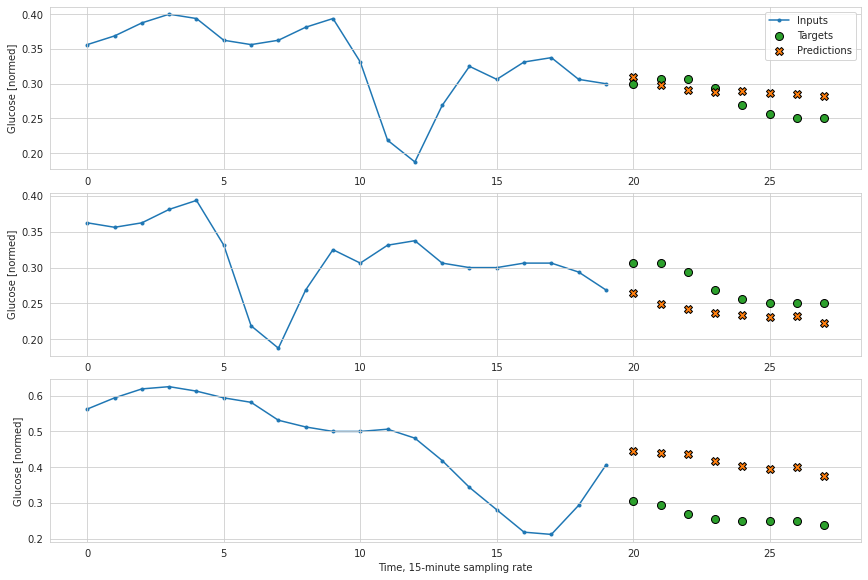

In [40]:
w.plot(model_multi_output, save_file="multi_output_predictions")

0  gaps identified


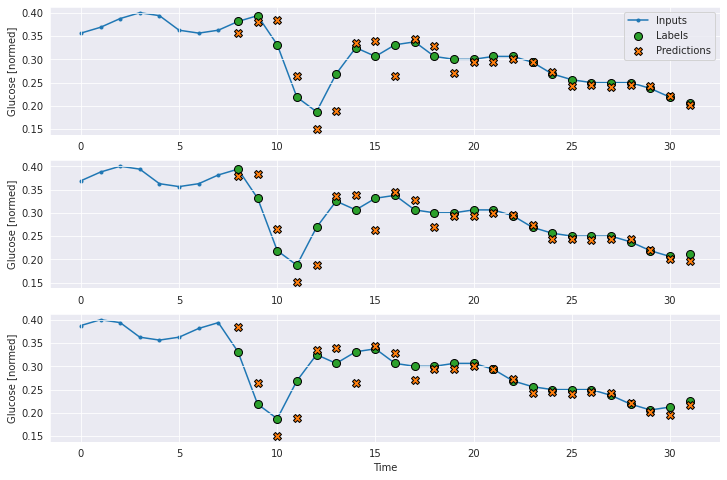

In [44]:
# Code for testing de-normalization works well
from sklearn.metrics import mean_squared_error

all_predictions = []
all_targets = []
for batch in window.val:
    inputs, targets = batch
    targets = targets.numpy().flatten()
    predictions = model.predict(inputs).flatten()

    # De-normalize
    d_max, d_min = min_max_scaler.data_max_[0], min_max_scaler.data_min_[0]
    targets = targets*(d_max - d_min) + d_min
    predictions = predictions*(d_max - d_min) + d_min

    all_predictions.extend(predictions)
    all_targets.extend(targets)

print(math.sqrt(mean_squared_error(all_targets, all_predictions)))

In [1206]:
from sklearn.metrics import mean_squared_error

all_predictions = []
all_targets = []
for batch in conv_window.val:
    inputs, targets = batch
    targets = targets.numpy().flatten()
    predictions = conv_model.predict(inputs).flatten()

    # De-normalize
    d_max, d_min = min_max_scaler.data_max_[0], min_max_scaler.data_min_[0]
    targets = targets*(d_max - d_min) + d_min
    predictions = predictions*(d_max - d_min) + d_min

    all_predictions.extend(predictions)
    all_targets.extend(targets)

print(math.sqrt(mean_squared_error(all_targets, all_predictions)))

0.5414185108376327


## Code below did not make it to the thesis

### Finding optimal FFNN architecture
Using the strategy defined in https://www.sciencedirect.com/science/article/pii/S020852161830127X?casa_token=Bfv_TBDDSigAAAAA:cchFJKcdq34Ch-eBhKjgKYu9bdsBIG2yQxRbSc1HRTP8nreq0C1GNHaBAtuO36d5uEKhdYt6oQ

In [ ]:
def find_architecture_paper(using_columns, activ_func="tanh"):
    # In 15min interval -> [15min, 30min, 45min, 60min]
    minutest_delta = 15
    prediction_horizons = [1, 2, 3]
    models = {f"{minutest_delta * i}min": None for i in prediction_horizons}

    for p_horizon in prediction_horizons:
        # Skip if we already found the model some time previously
        if models[f"{p_horizon * minutest_delta}min"] is not None:
            continue

        best_rmse = 100
        best_model, best_params = None, (None, None)
        # Hyper-parameter tuning:
        max_Nbin, max_Nbhid = 10, 10
        min_rmse = 10**-5
        found_min = False

        for hid_size in range(2, max_Nbhid + 1):
            if found_min:
                break
            print(f"Trying {hid_size} hidden")
            for in_size in range(2, max_Nbin + 1):
                print(f"IN {in_size}")
                w = get_window(using_columns, in_size, 1, p_horizon)

                dense = tf.keras.Sequential([
                    # Shape: (time, features) => (time*features)
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=hid_size, activation=activ_func),
                    tf.keras.layers.Dense(units=1),
                    # Add back the time dimension.
                    # Shape: (outputs) => (1, outputs)
                    tf.keras.layers.Reshape([1, -1]),
                ])

                compile_and_fit(dense, w, max_epochs=100, monitor='root_mean_squared_error')
                _, rmse = dense.evaluate(w.train)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model, best_params = dense, (in_size, hid_size)

                if rmse < min_rmse:
                    found_min = True
                    break

        models[f"{p_horizon * minutest_delta}min"] = (best_rmse, best_model, best_params)
    return models

gluc_only_models = find_architecture_paper(["Time", "Glucose"])